<a href="https://colab.research.google.com/github/mingrui-liu/Hyperpigmentation-autograde/blob/main/base_model_improvement_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam

In [ ]:
# connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
IMG_SIZE = 512

In [ ]:
#Create image tf dataset from directory 
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalize(x):
  x /= 127.5
  x -= 1.
  return x
  
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.clip_by_value(image, 0.0, 255.0)
  image = tf.cast(image, dtype=tf.uint8)
  return image



all_image_paths = sorted(glob.glob("/content/drive/My Drive/Unilever/image_test/*.jpg"))

#path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
#image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#DATASET_SIZE = len(image_ds)

In [ ]:
# read the excel file
MHPgrades = pd.read_excel("/content/drive/My Drive/Unilever/MHPgrades.xlsx")
grade = MHPgrades["Mottled hyperpigmentation"]

all_image_labels = list(grade)
#label_names = list(sorted(grade.unique()))
#label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.float32))

In [ ]:
all_label = []
for grade in all_image_labels:
  if grade < 2.0:
    label = 1.5
  elif grade > 4.0:
    label = 4.5
  else:
    label = grade
  all_label.append(label)

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(sorted(set(all_label))))
label_to_index

{1.5: 0, 2.0: 1, 2.5: 2, 3.0: 3, 3.5: 4, 4.0: 5, 4.5: 6}

In [ ]:
all_labels = [label_to_index[grade]
                    for grade in all_label]

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels) 

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
DATASET_SIZE = len(image_ds)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.float32))

In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(224, 224, 3) 6.0
(224, 224, 3) 0.0


using generator

In [ ]:
	# here's our final training dataset
	train_ds = image_label_ds.cache()
	train_ds = train_ds.shuffle(buffer_size = 1024)
	train_ds = train_ds.repeat()
	train_ds = train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image),label),num_parallel_calls=AUTOTUNE)

	#train_ds = train_ds.map(lambda image,label:(randaugment.distort_image_with_randaugment(image,num_layers = 2,magnitude = 2),label),num_parallel_calls=AUTOTUNE)
	train_ds = train_ds.map(lambda image,label:(normalize(tf.cast(image,tf.float32)),label),num_parallel_calls=AUTOTUNE)

	train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


	path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
	image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

	label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.float32))
	test_ds = tf.data.Dataset.zip((image_ds, label_ds))
	test_ds= test_ds.map(lambda image,label:(normalize(tf.cast(image,tf.float32)),label),num_parallel_calls=AUTOTUNE)
	
	test_ds = test_ds.cache().batch(BATCH_SIZE)



#### Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
conv_base = ResNet50(include_top = False, weights = 'imagenet',
                      input_shape = (512, 512, 3))




drop_out = tf.keras.layers.Dropout(.5, input_shape =(8, 16, 16,2048))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')


model = tf.keras.Sequential([
  conv_base,
  drop_out,
  global_average_layer,
  prediction_layer
])


#model = Model(inputs = conv_base.input, outputs=predictions)

lr_schedule  = tfa.optimizers.ExponentialCyclicalLearningRate(
                              initial_learning_rate=1e-8,
                              maximal_learning_rate=1e-4,
                              step_size=240,
                              )
opt = Adam(learning_rate=3e-4)

model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
      epochs = 200,
      steps_per_epoch = 40,
      validation_data = test_ds)

In [ ]:
def plot(history):
  
    plt.title('Training and validation accuracy')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(history.history['loss'][7:], label='loss')
    plt.plot(history.history['val_loss'][7:], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

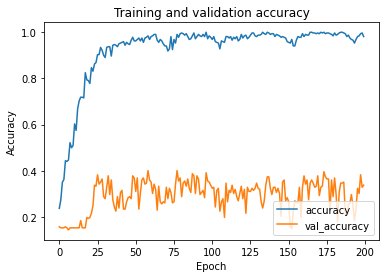

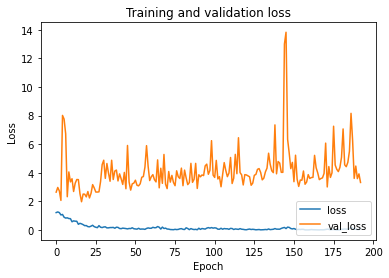

In [ ]:
plot(
history
)